# Quantum state preparation and unitary syntheis using Deep Q-Networks (DQN)

In [1]:
from environment.Qenv_unitary import Qenv_unitary_gym
from environment.Qenv_state import Qenv_state_gym
from environment.Qenv_state_ising import Qenv_ising_state_gym
from environment.Qsim import Ising_Hamiltonian
import agents.agents as Agents
from utils import *
import os
import torch as pt
from stable_baselines3.common.monitor import Monitor

device = pt.device('cuda:0' if pt.cuda.is_available() else 'cpu')

Define parameters

Here you can see how to define the parameters for the three environments as well as for the agent

In [2]:
# Parameters for unitary environment
env_params_unitary = dict(
    N=2,
    goals=None,
    num_goals=1,
    max_steps=10, 
    fidelity_threshold=0.99,
    fidelity_function='Haar_integral',
    sparse_reward=False,
    qgates='HRC',
    adjoint=False,
    qubit_connectivity=None,
    device=device
)

In [3]:
# Parameters for state environment
env_params_state = dict(
    N=2,
    goals=None,
    num_goals=1,
    max_steps=10, 
    fidelity_threshold=0.99,
    sparse_reward=False,
    qgates='HRC',
    adjoint=False,
    inverse_circuit=False,
    obs_type='Single',
    qubit_connectivity=None,
    device=device)

In [4]:
# Parameters for Ising environment
experiment = 'A'    # Options: A, B

if experiment == 'A':
    starts_ = 'ground states'
    ground_state_params_ = dict(J = -1, gx = [1, 1.1], gz = 0)
    delta_t_ = 6.
    fidelity_threshold_ = 0.96
    env_name_ = 'case_A'
    target_state_params_ = dict(J = -1, gx = 0, gz = 0)

elif experiment == 'B':
    starts_ = 'ground states'
    ground_state_params_ = dict(J = -1, gx = [1, 1.1], gz = [0, 0.5])
    delta_t_ = 6.
    fidelity_threshold_ = 0.93
    env_name_ = 'case_B'
    target_state_params_ = dict(J = +1, gx = 0.5, gz = 1.5)

env_params_ising = dict(
    N = 4,
    starts = starts_,
    num_starts = -1,
    ground_states_params = ground_state_params_,
    delta_t = delta_t_,
    reward_function = 'log fidelity',
    max_steps = 50,
    fidelity_threshold = fidelity_threshold_,
    device=device)

# Get Ising goal
H, eigenvalues, eigenvectors = Ising_Hamiltonian(N=env_params_ising['N'], **target_state_params_)
goal = eigenvectors[0]
env_params_ising['goal'] = goal

In [5]:
env_type = 'ising'        # Options are 'unitary', 'state' and 'ising'

if env_type == 'unitary':
    env_params = env_params_unitary
elif env_type == 'state':
    env_params = env_params_state
elif env_type == 'ising':
    env_params = env_params_ising

# Training 
num_episodes = int(1e4)
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

# Agent
algo = 'DQN_agent'         # Options: 'DQN_agent', 'DDQN_agent', 'DuelDQN_agent', 'DuelDDQN_agent'
agent_params = dict(
    gamma = 0.98,
    lr = 1e-4,
    mem_size = int(8e3),
    batch_size = 64,
    N_eps = num_episodes,
    eps_max = 1.0,
    eps_min = 0.01,
    replace = (10,'step'),
    env_name = f"{env_params['N']}Q_{env_type}",
    chkpt_dir = log_dir)

Create environment

logs_env is a wrapper enviornment to save the results of each episode during training, they are saved in log_dir/monitor.csv

In [6]:
if env_type == 'unitary':
    env = Qenv_unitary_gym(**env_params)
elif env_type == 'state':
    env = Qenv_state_gym(**env_params)
elif env_type == 'ising':
    env = Qenv_ising_state_gym(**env_params)

logs_env = Monitor(env, filename=log_dir, info_keywords=("is_success", "Fidelity", "Goal", "Circuit"))

agent_params['input_dims'] = env.observation_space.shape[0]
agent_params['n_actions'] = env.action_space.n

Create agent

In [7]:
agent_ = getattr(Agents, algo)
model = agent_(**agent_params)

Train agent

In [8]:
fill_memory(env, model)
results_df = train_agent(logs_env, model, window = 100)

Done filling the memory
Episode 100: Sucess rate: 0.0 %, Avg fidelity: 0.507, Avg episode lenght: 50.0, epsilon 0.92
Episode 200: Sucess rate: 1.0 %, Avg fidelity: 0.546, Avg episode lenght: 49.6, epsilon 0.85
Episode 300: Sucess rate: 4.0 %, Avg fidelity: 0.661, Avg episode lenght: 48.5, epsilon 0.79
Episode 400: Sucess rate: 5.0 %, Avg fidelity: 0.715, Avg episode lenght: 48.5, epsilon 0.73
Episode 500: Sucess rate: 10.0 %, Avg fidelity: 0.744, Avg episode lenght: 46.8, epsilon 0.67
Episode 600: Sucess rate: 15.0 %, Avg fidelity: 0.786, Avg episode lenght: 45.4, epsilon 0.62
Episode 700: Sucess rate: 22.0 %, Avg fidelity: 0.834, Avg episode lenght: 42.8, epsilon 0.58
Episode 800: Sucess rate: 32.0 %, Avg fidelity: 0.864, Avg episode lenght: 39.0, epsilon 0.53
Episode 900: Sucess rate: 44.0 %, Avg fidelity: 0.883, Avg episode lenght: 34.6, epsilon 0.49
Episode 1000: Sucess rate: 54.0 %, Avg fidelity: 0.910, Avg episode lenght: 32.2, epsilon 0.45
Episode 1100: Sucess rate: 67.0 %, Avg 

Show results

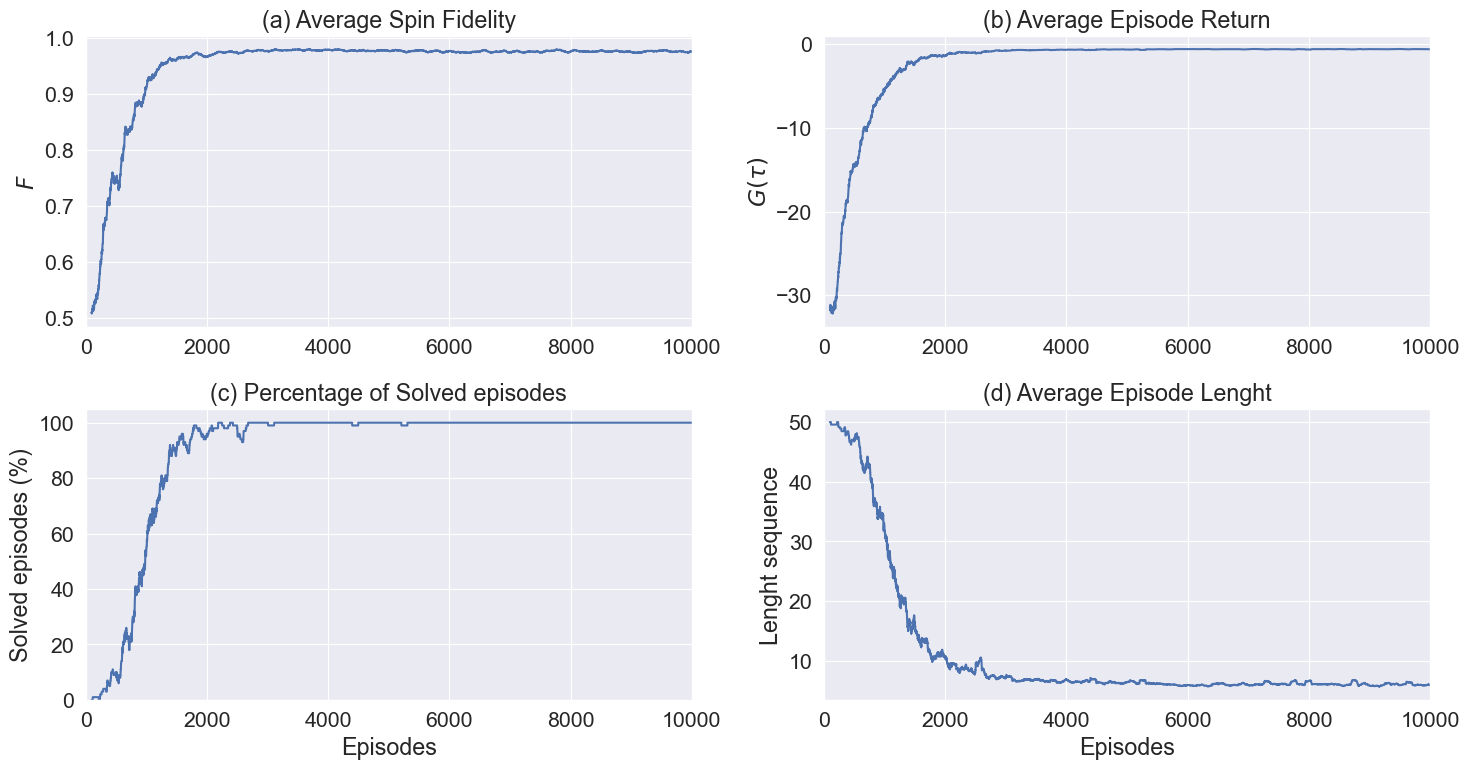

In [9]:
plot_results(results_df, window=int(100),type=env_type)

Test agent

When testing the agent we can vary the enviornment were is tested, as well as set the value of epsilon for epsilon-greedy policy

In [10]:
test_df = test_agent(env, model, episodes=int(1e2), epsilon=0)

Performance for 100 episodes:
    Sucess rate: 100.0 % 
    Avg fidelity: 0.970
    Avg episode lenght: 6.0


Save results

In [ ]:
model.save_models()